<h2><center> Welcome To This Weekendz Zindi Virtual Hackathon</h2></center>
<figure>
<center><img src ="https://drive.google.com/uc?export=view&id=1DhJN20aR_j0w2BcQSvxt2MjnTACOD2UM" width = "1300" height = '500'/>

*The objective of this challenge is*:
> To create an automatic speech recognition solution to classify simple Swahili audio into text.

Your solution will be used by telecommunication companies for voice or text prompts, or to help in translation, public health or emergency services.


## Table of contents:

1. [Importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Data Exploration](#Exploration)
4. [Feature engineering](#Engineering)
5. [Modelling](#Modelling)
6. [Predictions Explorations](#Predictions)
7. [Create Submission File](#Submission)
8. [Tips](#Tips)

In [ ]:
# Check gpu type
!nvidia-smi

Thu Aug  4 11:20:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<a name="Libraries"></a>
## 1. Importing libraries

In [ ]:
# Import libraries
import pandas as pd
import IPython.display as ipd
from matplotlib import pyplot as plt
import librosa
import os
import torch
import shutil
import random
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
# Set seed for reproducability
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
seed = 2022
seed_all(seed)

<a name="Data"></a>
## 2. Loading data

In [ ]:
# Load files
data_path = ''

train = pd.read_csv(data_path + '/Train.csv')
test = pd.read_csv(data_path + '/Test.csv')
samplesubmission = pd.read_csv(data_path + '/SampleSubmission.csv')

# Unzip audio zip file
shutil.unpack_archive(data_path + '/Swahili_words.zip', 'Swahili_words')

<a name="Exploration"></a>
## 3. Data Exploration

In [ ]:
# Preview train set
train.head()

,Word_id,Swahili_word,English_translation
0,id_v8rz06e6rv31.wav,mbili,two
1,id_vmbwicdpfn68.wav,tatu,three
2,id_injlouhxg1hg.wav,ndio,yes
3,id_gdq23p6xgzya.wav,nne,four
4,id_lpstklz51zpz.wav,nane,eight


In [ ]:
# Preview test set
display(test.head(), train.shape, test.shape)

,Word_id
0,id_jp2pxl0r84ya.wav
1,id_ndduqqvthbpx.wav
2,id_36oxymxfcm6q.wav
3,id_ue9b0to760pg.wav
4,id_prja4oprb914.wav


(4200, 3)

(1800, 1)

In [ ]:
# Preview sample submisiion file
samplesubmission.head()

,Word_id,hapana,kumi,mbili,moja,nane,ndio,nne,saba,sita,tano,tatu,tisa
0,id_jp2pxl0r84ya.wav,0,0,0,0,0,0,0,0,0,0,0,0
1,id_ndduqqvthbpx.wav,0,0,0,0,0,0,0,0,0,0,0,0
2,id_36oxymxfcm6q.wav,0,0,0,0,0,0,0,0,0,0,0,0
3,id_ue9b0to760pg.wav,0,0,0,0,0,0,0,0,0,0,0,0
4,id_prja4oprb914.wav,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Target distribution
train.Swahili_word.value_counts()

mbili     350
tatu      350
ndio      350
nne       350
nane      350
hapana    350
sita      350
tisa      350
moja      350
saba      350
tano      350
kumi      350
Name: Swahili_word, dtype: int64

In [ ]:
# Sample some words
for word in random.sample(train.Swahili_word.unique().tolist(), 6):
  sample = train[train.Swahili_word == word].Word_id.sample(1).values[0]
  display(word, sample, ipd.Audio('Swahili_words/'+ sample ))

'moja'

'id_gkywu3tot95q.wav'

'nane'

'id_l1k9bpnin5bx.wav'

'tisa'

'id_igolh47fxnmz.wav'

'kumi'

'id_4h4rs31429ji.wav'

'tano'

'id_b77niqs9exzl.wav'

'saba'

'id_b07vxoz6xdqd.wav'

<a name="Engineering"></a>
## 4. Feature Engineering

There are many ways to tackle this challenge. Try deep learning on the audio, generate a spectrogram and treat this as an image classification task, use some signal processing tricks to look for close matches, try to extract meaningful features such as dominant frequencies.... It's up to you :)

This blog (https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d) shows how to visualize different properties of the waveform, and some features you could use. 

For this example, I'll generate a square spectrogram and save as an image file.
Generating an image from an audio file through spectrograms

A [spectrogram](https://pnsn.org/spectrograms/what-is-a-spectrogram#:~:text=A%20spectrogram%20is%20a%20visual,energy%20levels%20vary%20over%20time.) is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.  Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

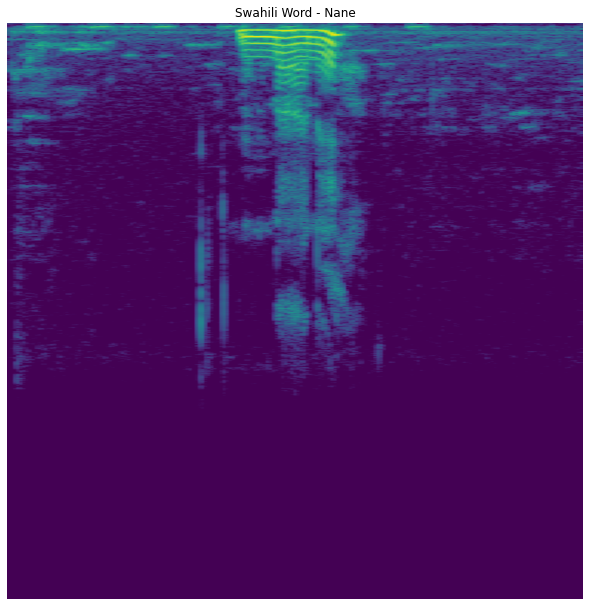

In [ ]:
# Going from a sound to an image: spectrograms
os.mkdir('spectrograms') # Create a folder to store the spectrograms

# Function to generate spectrogram
def gen_spectrogram(path):
  x , sr = librosa.load(path)
  X = librosa.stft(x)
  Xdb = librosa.amplitude_to_db(abs(X)[:,:min(1025, len(X[0]))])
  fig = plt.figure(frameon=False)
  fig.set_size_inches(8, 8)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  plt.title('Swahili Word - Nane')
  ax.imshow(Xdb, aspect='auto')
  spec_path = 'spectrograms/' + path.split('/')[1][:-4] +'.png'
  fig.savefig(spec_path, dpi=512//8)

gen_spectrogram('Swahili_words/id_pwvzavl2dl6q.wav')
display(ipd.Audio('Swahili_words/id_pwvzavl2dl6q.wav'))

In [ ]:
# Concatenate train with test for easy data manipulation
train_test_files = train.Word_id.tolist() + test.Word_id.tolist()

for word_id in tqdm(train_test_files):
  # Check if we've already generated a spectrogram, and if not, make one
  spec_path = 'spectrograms/' + word_id[:-4] +'.png'
  if not os.path.isfile(spec_path):
    plt.clf()
    gen_spectrogram('Swahili_words/'+ word_id)
  ipd.clear_output(wait=True)
  plt.close()

<Figure size 432x288 with 0 Axes>

In [ ]:
# Checking that the spectrograms were generated successfully:
len(os.listdir('Swahili_words')) == len(os.listdir('spectrograms')), len(os.listdir('spectrograms'))

(True, 6000)

In [ ]:
# Add spectrogram path to train set
train['spec_name'] = [x.split('.')[0] + '.png' for x in train.Word_id]

# Preview train
train.head()

,Word_id,Swahili_word,English_translation,spec_name
0,id_v8rz06e6rv31.wav,mbili,two,id_v8rz06e6rv31.png
1,id_vmbwicdpfn68.wav,tatu,three,id_vmbwicdpfn68.png
2,id_injlouhxg1hg.wav,ndio,yes,id_injlouhxg1hg.png
3,id_gdq23p6xgzya.wav,nne,four,id_gdq23p6xgzya.png
4,id_lpstklz51zpz.wav,nane,eight,id_lpstklz51zpz.png


<a name="Modelling"></a>
## 5. Modelling

In [ ]:
from fastai.vision.all import *

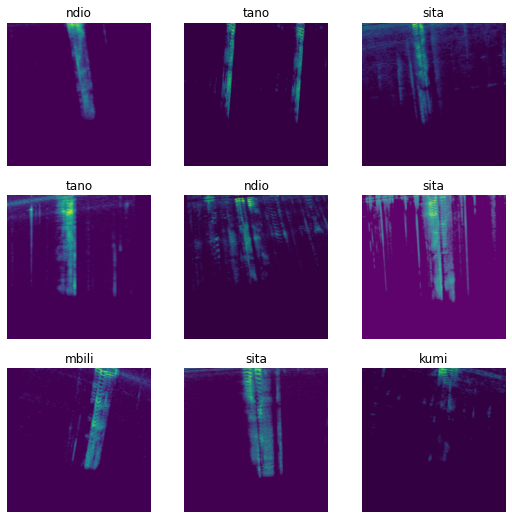

In [ ]:
# Create the dataloaders
dls = ImageDataLoaders.from_df(train, fn_col='spec_name', label_col='Swahili_word', 
                               folder='spectrograms', item_tfms=Resize(400),
                               batch_tfms = aug_transforms(size=224))
dls.show_batch() # Note the augmentation applied to the images!

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,3.469826,2.239075,0.725000,00:20


epoch,train_loss,valid_loss,error_rate,time
0,2.454878,1.547065,0.500000,00:18
1,1.799352,1.142224,0.335714,00:17
2,1.322505,0.895218,0.290476,00:17
3,1.067394,0.831365,0.267857,00:17


<a name="Predictions"></a>
## 6. Predictions Exploration

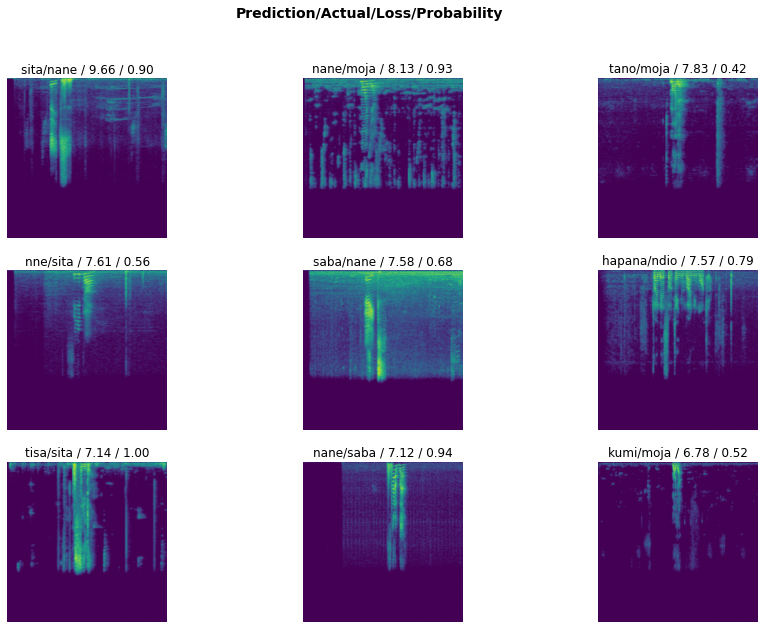

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

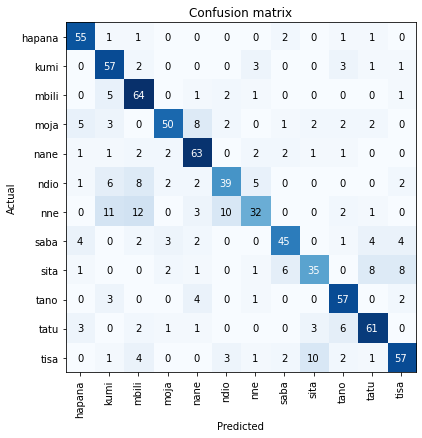

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6))

<a name="Submission"></a>
## 7. Create Submission File

In [ ]:
test = pd.read_csv(data_path + '/Test.csv')
test['spec_name'] = [x.split('.')[0] + '.png' for x in test.Word_id]

preds, _ = learn.get_preds(dl=dls.test_dl(test)) 
preds.shape

torch.Size([1800, 12])

In [ ]:
learn.dls.vocab # The labels in the order used by the model (alphabetical)

['hapana', 'kumi', 'mbili', 'moja', 'nane', 'ndio', 'nne', 'saba', 'sita', 'tano', 'tatu', 'tisa']

In [ ]:
samplesubmission.head()

,Word_id,hapana,kumi,mbili,moja,nane,ndio,nne,saba,sita,tano,tatu,tisa
0,id_jp2pxl0r84ya.wav,0,0,0,0,0,0,0,0,0,0,0,0
1,id_ndduqqvthbpx.wav,0,0,0,0,0,0,0,0,0,0,0,0
2,id_36oxymxfcm6q.wav,0,0,0,0,0,0,0,0,0,0,0,0
3,id_ue9b0to760pg.wav,0,0,0,0,0,0,0,0,0,0,0,0
4,id_prja4oprb914.wav,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
submission = pd.DataFrame({'Word_id': test['Word_id']})
for i, label in enumerate(learn.dls.vocab):
  submission[label] = preds[:,i].numpy()
submission.head()

,Word_id,hapana,kumi,mbili,moja,nane,ndio,nne,saba,sita,tano,tatu,tisa
0,id_jp2pxl0r84ya.wav,3.625237e-06,4.923109e-08,6.741069e-07,3.563996e-04,5.519177e-08,8.532032e-05,1.282484e-07,3.465266e-04,0.998725,1.734808e-07,1.255710e-04,0.000357
1,id_ndduqqvthbpx.wav,1.307622e-09,3.460961e-08,4.874955e-06,4.422550e-09,2.563630e-10,2.462666e-07,1.657265e-08,5.035998e-07,0.000001,8.259934e-06,4.860560e-08,0.999985
2,id_36oxymxfcm6q.wav,2.972752e-06,6.246864e-05,4.299168e-05,6.302043e-06,7.777376e-08,1.593151e-04,2.565814e-05,4.701162e-04,0.003407,1.087277e-04,1.110601e-04,0.995603
3,id_ue9b0to760pg.wav,4.162856e-06,2.113502e-05,4.886247e-06,2.987524e-04,1.838831e-05,1.573688e-04,1.434325e-04,4.388248e-03,0.000008,9.917031e-01,1.332807e-04,0.003120
4,id_prja4oprb914.wav,2.015496e-02,2.141140e-01,2.304197e-02,1.322708e-02,4.950216e-02,9.781761e-03,5.443539e-03,2.870786e-02,0.013642,4.437285e-01,1.082082e-01,0.070448


In [ ]:
submission.to_csv('starter_nb_submission.csv', index=False)

<a name="Tips"></a>
## 8. Tips

### 1) Refining the process above

The above method (training an image classifier on spectrograms) can do decently. Some ways to improve the score:
- Increase the image size
- Train a little more, or try different models
- 'Crop' the inputs, both to show a shorter clip of audio and a smaller frequency range
- Experiment with different ways of displaying the spectrgram. Log scale on the frequency axis. More striking colour maps. Maybe some audio cleaning and pre-processing...

### 2) Extracting other features

Look at other approaches people take for audio ML tasks. Mel Spectrograms, amplitude plots, various acoustic parameters... there's a whole world of audio-related weirdness you can explore. These kinds of features can then be fed into your ML algorithm of choice.  

### 3) Tackle 'background noise'

### 4) Make friends with someone who does Signal Processing

There are signal processing techniques that seem like magic to anyone not used to thinking in the fourier domain. I don't have specific recommendations for things to check out here, but if you do happen to know somebody with skills in this area I suspect it'll be worth offering them a share of your glory in exchange for some tips. :)

### 5) Look around to see what the State of the Art is for audio classification

Using an image recognition pipeline for audio classification is a bit of a hack. Take a look at some recent publications to see what the cool kids are using. 

### 6) Get creative!

Good luck and have fun :)